In [1]:
import numpy as np
import random
import math
import time
'''
数据集：伪造数据集（两个高斯分布混合）
数据集长度：1000
------------------------------
运行结果：
----------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.4, mu0:0.6, sigmod0:-1.7, alpha1:0.7, mu1:0.7, sigmod1:0.9
----------------------------
'''

def loadData(mu0, sigma0, mu1, sigma1, alpha0, alpha1):
    '''
    初始化数据集
    这里通过服从高斯分布的随机函数来伪造数据集
    :param mu0: 高斯0的均值
    :param sigma0: 高斯0的方差
    :param mu1: 高斯1的均值
    :param sigma1: 高斯1的方差
    :param alpha0: 高斯0的系数
    :param alpha1: 高斯1的系数
    :return: 混合了两个高斯分布的数据
    '''
    # 定义数据集长度为1000
    length = 1000

    # 初始化第一个高斯分布，生成数据，数据长度为length * alpha系数，以此来
    # 满足alpha的作用
    data0 = np.random.normal(mu0, sigma0, int(length * alpha0))
    # 第二个高斯分布的数据
    data1 = np.random.normal(mu1, sigma1, int(length * alpha1))

    # 初始化总数据集
    # 两个高斯分布的数据混合后会放在该数据集中返回
    dataSet = []
    # 将第一个数据集的内容添加进去
    dataSet.extend(data0)
    # 添加第二个数据集的数据
    dataSet.extend(data1)
    # 对总的数据集进行打乱（其实不打乱也没事，只不过打乱一下直观上让人感觉已经混合了
    # 读者可以将下面这句话屏蔽以后看看效果是否有差别）
    random.shuffle(dataSet)

    #返回伪造好的数据集
    return dataSet



In [3]:

# 高斯分布公式，没有什么特殊的
def calcGauss(dataSetArr, mu, sigmod):
    '''
    根据高斯密度函数计算值
    依据：“9.3.1 高斯混合模型” 式9.25
    注：在公式中y是一个实数，但是在EM算法中(见算法9.2的E步)，需要对每个j
    都求一次yjk，在本实例中有1000个可观测数据，因此需要计算1000次。考虑到
    在E步时进行1000次高斯计算，程序上比较不简洁，因此这里的y是向量，在numpy
    的exp中如果exp内部值为向量，则对向量中每个值进行exp，输出仍是向量的形式。
    所以使用向量的形式1次计算即可将所有计算结果得出，程序上较为简洁
    
    :param dataSetArr: 可观测数据集
    :param mu: 均值
    :param sigmod: 方差
    :return: 整个可观测数据集的高斯分布密度（向量形式）
    '''
    # 计算过程就是依据式9.25写的，没有别的花样
    result = (1 / (math.sqrt(2*math.pi)*sigmod**2)) * np.exp(-1 * (dataSetArr-mu) * (dataSetArr-mu) / (2*sigmod**2))
    # 返回结果
    return result


def E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1):
    '''
    EM算法中的E步
    依据当前模型参数，计算分模型k对观数据y的响应度
    :param dataSetArr: 可观测数据y
    :param alpha0: 高斯模型0的系数
    :param mu0: 高斯模型0的均值
    :param sigmod0: 高斯模型0的方差
    :param alpha1: 高斯模型1的系数
    :param mu1: 高斯模型1的均值
    :param sigmod1: 高斯模型1的方差
    :return: 两个模型各自的响应度
    '''
    # 计算y0的响应度
    # 先计算模型0的响应度的分子
    gamma0 = alpha0 * calcGauss(dataSetArr, mu0, sigmod0)
    #print("gamma0=",gamma0.shape) # 1000, 维向量
    # 模型1响应度的分子
    gamma1 = alpha1 * calcGauss(dataSetArr, mu1, sigmod1)

    # 两者相加为E步中的分布
    sum = gamma0 + gamma1
    # 各自相除，得到两个模型的响应度
    gamma0 = gamma0 / sum
    gamma1 = gamma1 / sum

    # 返回两个模型响应度
    return gamma0, gamma1

def M_step(muo, mu1, gamma0, gamma1, dataSetArr):
    # 依据算法9.2计算各个值
    # 这里没什么花样，对照书本公式看看这里就好了
    
    # np.dot 点积：[1,2] [2,3] = [2,6]
    mu0_new = np.dot(gamma0, dataSetArr) / np.sum(gamma0)
    mu1_new = np.dot(gamma1, dataSetArr) / np.sum(gamma1)

    # math.sqrt  平方根 
    sigmod0_new = math.sqrt(np.dot(gamma0, (dataSetArr - muo)**2) / np.sum(gamma0))
    sigmod1_new = math.sqrt(np.dot(gamma1, (dataSetArr - mu1)**2) / np.sum(gamma1))

    alpha0_new = np.sum(gamma0) / len(gamma0)
    alpha1_new = np.sum(gamma1) / len(gamma1)

    # 将更新的值返回
    return mu0_new, mu1_new, sigmod0_new, sigmod1_new, alpha0_new, alpha1_new


## 训练主函数
def EM_Train(dataSetList, iter=500):
    '''
    根据EM算法进行参数估计
    算法依据“9.3.2 高斯混合模型参数估计的EM算法” 算法9.2
    :param dataSetList:数据集（可观测数据）
    :param iter: 迭代次数
    :return: 估计的参数
    '''
    # 将可观测数据y转换为数组形式，主要是为了方便后续运算
    dataSetArr = np.array(dataSetList)

    # 步骤1：对参数取初值，开始迭代
    alpha0 = 0.5
    mu0 = 0
    sigmod0 = 1
    alpha1 = 0.5
    mu1 = 1
    sigmod1 = 1

    # 开始迭代
    step = 0
    while (step < iter):
        # 每次进入一次迭代后迭代次数加1
        step += 1
        # 步骤2：E步：依据当前模型参数，计算分模型k对观测数据y的响应度
        gamma0, gamma1 = E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1)
        # 步骤3：M步
        mu0, mu1, sigmod0, sigmod1, alpha0, alpha1 = M_step(mu0, mu1, gamma0, gamma1, dataSetArr)

    # 迭代结束后将更新后的各参数返回
    return alpha0, mu0, sigmod0, alpha1, mu1, sigmod1



In [4]:


if __name__ == '__main__':
    start = time.time()

    # 设置两个高斯模型进行混合，这里是初始化两个模型各自的参数
    # 见“9.3 EM算法在高斯混合模型学习中的应用”
    # alpha是“9.3.1 高斯混合模型” 定义9.2中的系数α
    # mu0是均值μ
    # sigmod是方差σ
    # 在设置上两个alpha的和必须为1，其他没有什么具体要求，符合高斯定义就可以
    
    alpha0 = 0.3  # 系数α
    mu0 = -2  # 均值μ
    sigmod0 = 0.5  # 方差σ

    alpha1 = 0.7  # 系数α
    mu1 = 0.5  # 均值μ
    sigmod1 = 1  # 方差σ

    # 初始化数据集
    dataSetList = loadData(mu0, sigmod0, mu1, sigmod1, alpha0, alpha1)

    #打印设置的参数
    print('---------------------------')
    print('the Parameters set is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 开始EM算法，进行参数估计
    alpha0, mu0, sigmod0, alpha1, mu1, sigmod1 = EM_Train(dataSetList)

    # 打印参数预测结果
    print('----------------------------')
    print('the Parameters predict is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 打印时间
    print('----------------------------')
    print('time span:', time.time() - start)


---------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.4, mu0:0.6, sigmod0:-1.8, alpha1:0.7, mu1:0.6, sigmod1:0.9
----------------------------
time span: 0.10124659538269043


In [5]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
#生成随机数据，4个高斯模型
def generate_data(sigma,N,mu1,mu2,mu3,mu4,alpha):
    global X                  #可观测数据集
    X = np.zeros((N, 2))       # 初始化X，2行N列。2维数据，N个样本
    X=np.matrix(X)
    global mu                 #随机初始化mu1，mu2，mu3，mu4
    mu = np.random.random((4,2))
    mu=np.matrix(mu)
    global excep              #期望第i个样本属于第j个模型的概率的期望
    excep=np.zeros((N,4))
    global alpha_             #初始化混合项系数
    alpha_=[0.25,0.25,0.25,0.25]
    for i in range(N):
        if np.random.random(1) < 0.1:  # 生成0-1之间随机数
            X[i,:]  = np.random.multivariate_normal(mu1, sigma, 1)     #用第一个高斯模型生成2维数据
        elif 0.1 <= np.random.random(1) < 0.3:
            X[i,:] = np.random.multivariate_normal(mu2, sigma, 1)      #用第二个高斯模型生成2维数据
        elif 0.3 <= np.random.random(1) < 0.6:
            X[i,:] = np.random.multivariate_normal(mu3, sigma, 1)      #用第三个高斯模型生成2维数据
        else:
            X[i,:] = np.random.multivariate_normal(mu4, sigma, 1)      #用第四个高斯模型生成2维数据
 
    print("可观测数据：\n",X)       #输出可观测样本
    print("初始化的mu1，mu2，mu3，mu4：",mu)      #输出初始化的mu


    
    
    
# # E 期望
# #  \hat{\gamma_{jk}}
# def e_step(sigma,k,N):
#     global X
#     global mu
#     global excep
#     global alpha_
#     for i in range(N):
#         denom=0
#         for j in range(0,k):
#             #  sigma.I 表示矩阵的逆矩阵
#             # np.transpose ：矩阵转置   np.linalg.det():矩阵求行列式
#             denom += alpha_[j]*  math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))  /np.sqrt(np.linalg.det(sigma))       #分母
#         for j in range(0,k):
#             numer = math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/np.sqrt(np.linalg.det(sigma))        #分子
#             excep[i,j]=alpha_[j]*numer/denom      #求期望
#     print("隐藏变量：\n",excep)

    
# def m_step(k,N):
#     global excep
#     global X
#     global alpha_
#     for j in range(0,k):
#         denom=0   #分母
#         numer=0   #分子
#         for i in range(N):
#             numer += excep[i,j]*X[i,:]
#             denom += excep[i,j]
#         mu[j,:] = numer/denom    #求均值
#         alpha_[j]=denom/N        #求混合项系数

#         #     #可视化结果
def plotShow():
    # 画生成的原始数据
    plt.subplot(221)
    plt.scatter(X[:,0].tolist(), X[:,1].tolist(),c='b',s=25,alpha=0.4,marker='o')    #T散点颜色，s散点大小，alpha透明度，marker散点形状
    plt.title('random generated data')
    #画分类好的数据
    plt.subplot(222)
    plt.title('classified data through EM')
    order=np.zeros(N)
    color=['b','r','k','y']
    for i in range(N):
        for j in range(k):
            if excep[i,j]==max(excep[i,:]):
                order[i]=j     #选出X[i,:]属于第几个高斯模型
            probility[i] += alpha_[int(order[i])]*math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/(np.sqrt(np.linalg.det(sigma))*2*np.pi)    #计算混合高斯分布
        plt.scatter(X[i, 0], X[i, 1], c=color[int(order[i])], s=25, alpha=0.4, marker='o')      #绘制分类后的散点图
    #绘制三维图像
    ax = plt.subplot(223, projection='3d')
    plt.title('3d view')
    for i in range(N):
        ax.scatter(X[i, 0], X[i, 1], probility[i], c=color[int(order[i])])
    plt.show()
                       


In [6]:
        
if __name__ == '__main__':
    iter_num=1000  #迭代次数
    N=500         #样本数目
    k=4            #高斯模型数
    probility = np.zeros(N)    #混合高斯分布
    u1=[5,35]
    u2=[30,40]
    u3=[20,20]
    u4=[45,15]
    sigma=np.matrix([[30, 0], [0, 30]])               #协方差矩阵
    alpha=[0.1,0.2,0.3,0.4]         #混合项系数
    generate_data(sigma,N,u1,u2,u3,u4,alpha)     #生成数据
    #迭代计算
    for i in range(iter_num):
        err=0     #均值误差
        err_alpha=0    #混合项系数误差
        Old_mu = copy.deepcopy(mu)
        Old_alpha = copy.deepcopy(alpha_)
        
        e_step(sigma,k,N)     # E步
        m_step(k,N)           # M步
        
        print("迭代次数:",i+1)
        print("估计的均值:",mu)
        print("估计的混合项系数:",alpha_)
        for z in range(k):
            err += (abs(Old_mu[z,0]-mu[z,0])+abs(Old_mu[z,1]-mu[z,1]))      #计算误差
            err_alpha += abs(Old_alpha[z]-alpha_[z])
        if (err<=0.001) and (err_alpha<0.001):     #达到精度退出迭代
            print(err,err_alpha)
            break


可观测数据：
 [[51.93080514 13.24031443]
 [49.20546514 16.07813736]
 [44.55276652 13.30302232]
 [23.11299828 22.43810912]
 [49.56174424 12.47978035]
 [20.15256637 18.66205163]
 [32.94699483 47.26522242]
 [44.22750893 17.940652  ]
 [ 3.51801368 28.19653257]
 [29.55065463 36.94443037]
 [48.24916418 17.44757253]
 [41.23629791 38.17499412]
 [ 6.72037097 26.72374828]
 [ 7.78840341 32.94069698]
 [25.73549543 13.498284  ]
 [51.48812094 11.7384848 ]
 [46.76508031 19.39607915]
 [49.38504389 12.00444722]
 [22.94228642 11.87401789]
 [42.91237716 11.81068938]
 [43.64949479 20.84516322]
 [35.92267201 19.30622293]
 [20.77731719 18.79646847]
 [17.46800714 21.9701905 ]
 [45.87610317 18.08909023]
 [51.41035721  7.09597843]
 [53.45991616  6.19887571]
 [41.81771801 14.80694399]
 [24.35226426 46.45120817]
 [44.16296534 18.11962391]
 [40.8354404  12.01706779]
 [52.3116269  17.86953736]
 [46.86735365 16.08029665]
 [26.81763056 39.39849805]
 [58.27020461 19.00662858]
 [51.30944079 16.94106484]
 [45.14825123  8.141

隐藏变量：
 [[0.32016474 0.09459704 0.30023736 0.28500086]
 [0.30544588 0.09382403 0.31452903 0.28620106]
 [0.30601398 0.10616653 0.30399586 0.28382364]
 ...
 [0.3058126  0.10256667 0.30707    0.28455073]
 [0.31724338 0.10998452 0.29065169 0.28212042]
 [0.31006369 0.13445829 0.27836355 0.27711448]]
迭代次数: 1
估计的均值: [[36.17370825 20.19894491]
 [31.71579671 21.45151239]
 [31.92178923 24.23852125]
 [33.74059065 22.27175971]]
估计的混合项系数: [0.2601025638848706, 0.10753449819316777, 0.3510464494980968, 0.2813164884238655]
隐藏变量：
 [[9.75959010e-01 1.02166437e-03 7.37990315e-04 2.22813351e-02]
 [9.44218717e-01 2.81594028e-03 3.31972236e-03 4.96456208e-02]
 [9.15862396e-01 8.63500709e-03 5.70245454e-03 6.98001421e-02]
 ...
 [9.24789476e-01 6.36190384e-03 4.95903415e-03 6.38895865e-02]
 [9.51049405e-01 5.26945891e-03 2.07315823e-03 4.16079780e-02]
 [8.39424287e-01 5.18922185e-02 9.43759700e-03 9.92458975e-02]]
迭代次数: 2
估计的均值: [[45.98497439 14.19829553]
 [20.49101307 20.42810647]
 [19.89863464 33.34807049]
 [

隐藏变量：
 [[1.00000000e+00 2.13937529e-16 3.85977852e-40 1.96514838e-18]
 [1.00000000e+00 8.04819820e-14 3.12624842e-35 4.67149932e-15]
 [1.00000000e+00 7.04949950e-11 2.58316695e-31 5.89580823e-15]
 ...
 [1.00000000e+00 1.10074026e-11 2.23304307e-32 5.83235336e-15]
 [1.00000000e+00 3.69117405e-12 3.66094154e-34 1.53791648e-17]
 [9.99995108e-01 4.89170605e-06 2.28188900e-25 6.74233842e-16]]
迭代次数: 15
估计的均值: [[45.61485083 14.57485327]
 [19.84004064 21.16677797]
 [ 4.47140485 34.80260771]
 [29.55535982 40.24160637]]
估计的混合项系数: [0.5347084793145483, 0.18738741858914712, 0.11181432370348392, 0.1660897783928209]
0.0004409475879656455 4.153460822220456e-06


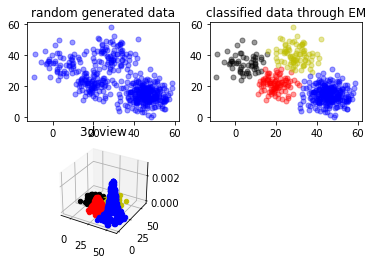

In [7]:
plotShow()